In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"

import sys
import matplotlib.patches as mpatches

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

def eval (out, model, label):
    probs = model.activate(out)
    unc = model.aleatoric(out).cpu()
    pmax = probs.argmax(dim=1)
    lmax = label.argmax(dim=1)
    mis = pmax.cpu() != lmax.cpu()

    agree = mis.bool() == (unc > .5)

    return agree.float().mean().item()


In [3]:
from datasets.nuscenes import *
from datasets.carla import *

from models.evidential import *
from models.postnet import *

from tools.utils import *
from tools.loss import *

%matplotlib inline
import matplotlib as mpl
from tqdm.notebook import tqdm, trange

In [6]:
import matplotlib.pyplot as plt
plt.rcParams["font.family"] = "Times New Roman"

In [7]:
baseline = Baseline([7], backbone="lss")
baseline.load(torch.load("../outputs/viz/lss_ce/19.pt"))

Loaded pretrained weights for efficientnet-b0


In [8]:
evidential = Evidential([7], backbone="lss")
evidential.load(torch.load("../outputs/carla/lss_evidential/9.pt"))

Loaded pretrained weights for efficientnet-b0


In [9]:
postnet = Postnet([7], backbone="lss")
postnet.load(torch.load("../outputs/carla/lss_postnet/9.pt"))

Loaded pretrained weights for efficientnet-b0


In [10]:
dropout = Dropout([7], backbone="lss")
dropout.eval()
dropout.load(torch.load("../outputs/carla/lss_baseline/9.pt"))

Loaded pretrained weights for efficientnet-b0


In [11]:
ensemble = Ensemble([7], backbone="lss")
ensemble.load(torch.load("../outputs/carla/lss_ensemble/9.pt"))

Ensemble activation
Loaded pretrained weights for efficientnet-b0
Loaded pretrained weights for efficientnet-b0
Loaded pretrained weights for efficientnet-b0


In [12]:
nusc, dataroot = get_nusc("trainval", "../../data/nuscenes")
nusc_data = NuScenesDataset(nusc, False)

In [315]:
nusc_data = CarlaDataset("../../data/carla/train", False)

In [51]:
ood_data = CarlaDataset("../../data/carla/ood", False)

In [52]:
images, intrinsics, extrinsics, labels, oods = ood_data[120]

In [53]:

images = images[None].to(7)
intrinsics = intrinsics[None].to(7)
extrinsics = extrinsics[None].to(7)
labels = labels[None].to(7)

logits = evidential(images, intrinsics, extrinsics).detach().cpu()
preds = evidential.activate(logits)

RuntimeError: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 2 is not equal to len(dims) = 3

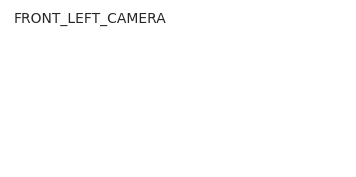

In [46]:
rat = 224/480
val = 10.1
fig = plt.figure(figsize=(val + val/3*2*rat*3, val/3*2*rat))
gs = mpl.gridspec.GridSpec(2, 6, width_ratios=(1, 1, 1, 2*rat, 2*rat, 2*rat))
gs.update(wspace=0.0, hspace=0.0, left=0.0, right=1.0, top=1.0, bottom=0.0)

for ci in range(6):
    ax = plt.subplot(gs[ci // 3, ci % 3])
    plt.annotate(cam_names[ci], (0.01, 0.92), xycoords='axes fraction')
    ax.axis('off')
    image = images[0, ci].cpu().permute(1, 2, 0).numpy()
    ax.imshow(image) 

ax = plt.subplot(gs[:, 3:4])
ax.imshow(map_rgb(preds[0]) / 255)
ax.axis("off")
    
ax = plt.subplot(gs[:, 4:5])
ax.imshow(map_rgb(labels[0]) / 255)
ax.axis("off")

ax = plt.subplot(gs[:, 5:6])
ax.imshow(evidential.epistemic(logits)[0, 0], cmap='jet')
ax.axis("off")

(-0.5, 199.5, 199.5, -0.5)

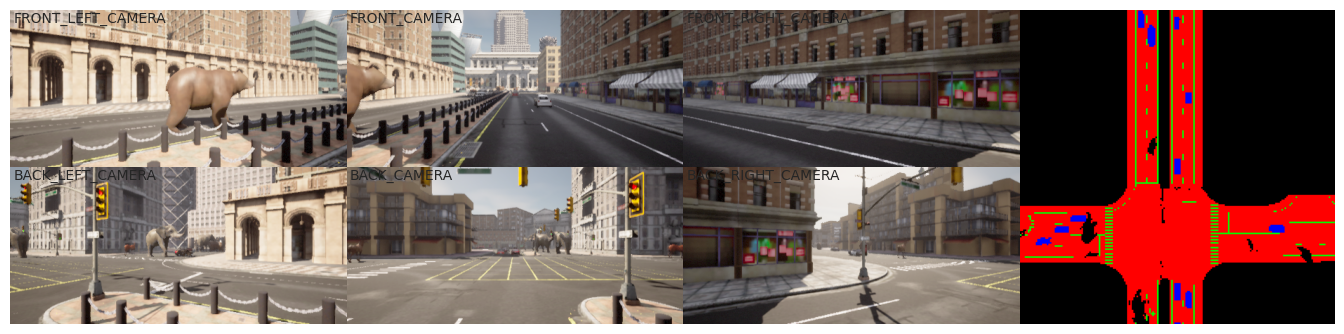

In [54]:
rat = 224/480
val = 10.1
fig = plt.figure(figsize=(val + val/3*2*rat, val/3*2*rat))
gs = mpl.gridspec.GridSpec(2, 4, width_ratios=(1, 1, 1, 2*rat))
gs.update(wspace=0.0, hspace=0.0, left=0.0, right=1.0, top=1.0, bottom=0.0)

for ci in range(6):
    ax = plt.subplot(gs[ci // 3, ci % 3])
    plt.annotate(cam_names[ci], (0.01, 0.92), xycoords='axes fraction')
    ax.axis('off')
    image = images[0, ci].cpu().permute(1, 2, 0).numpy()
    ax.imshow(image) 


ax = plt.subplot(gs[:, 3:4])
ax.imshow(map_rgb(labels[0]) / 255)
ax.axis("off")

In [33]:
logits.shape

torch.Size([1, 4, 200, 200])

In [16]:
cam_names = [
    "FRONT_LEFT_CAMERA",
    "FRONT_CAMERA",
    "FRONT_RIGHT_CAMERA",
    "BACK_LEFT_CAMERA",
    "BACK_CAMERA",
    "BACK_RIGHT_CAMERA",
]

One row cameras + bevss + UQs

In [ ]:
rat = 224/480
val = 10.1
fig = plt.figure(figsize=(val + val/3*2*rat*3, val/3*2*rat))
gs = mpl.gridspec.GridSpec(2, 6, width_ratios=(1, 1, 1, 2*rat, 2*rat, 2*rat))
gs.update(wspace=0.0, hspace=0.0, left=0.0, right=1.0, top=1.0, bottom=0.0)

save = 'nuscenes_frames'
os.makedirs(save, exist_ok=True)

for i in range(100):
    images, intrinsics, extrinsics, labels, ood = nusc_data[i]
    images = images[None].to(7)
    intrinsics = intrinsics[None].to(7)
    extrinsics = extrinsics[None].to(7)
    labels = labels[None].to(7)

    logits = evidential(images, intrinsics, extrinsics).detach().cpu()
    preds = evidential.activate(logits)
    
    for ci in range(6):
        ax = plt.subplot(gs[ci // 3, ci % 3])
        plt.annotate(cam_names[ci], (0.01, 0.92), xycoords='axes fraction')
        ax.axis('off')
        image = images[0, ci].cpu().permute(1, 2, 0).numpy()
        ax.imshow(image)
            
    ax = plt.subplot(gs[:, 3:4])
    ax.imshow(map_rgb(preds[0]) / 255)
    ax.axis("off")
    
    ax = plt.subplot(gs[:, 4:5])
    ax.imshow(model.aleatoric(logits)[0, 0], cmap='jet')
    ax.axis("off")

    ax = plt.subplot(gs[:, 5:6])
    ax.imshow(model.epistemic(logits)[0, 0], cmap='jet')
    ax.axis("off")

    fig.savefig(f"{save}/{i}.png")
    plt.clf()


Samples comparison BSLN vs. EDL

  0%|          | 0/100 [00:00<?, ?it/s]

findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans.


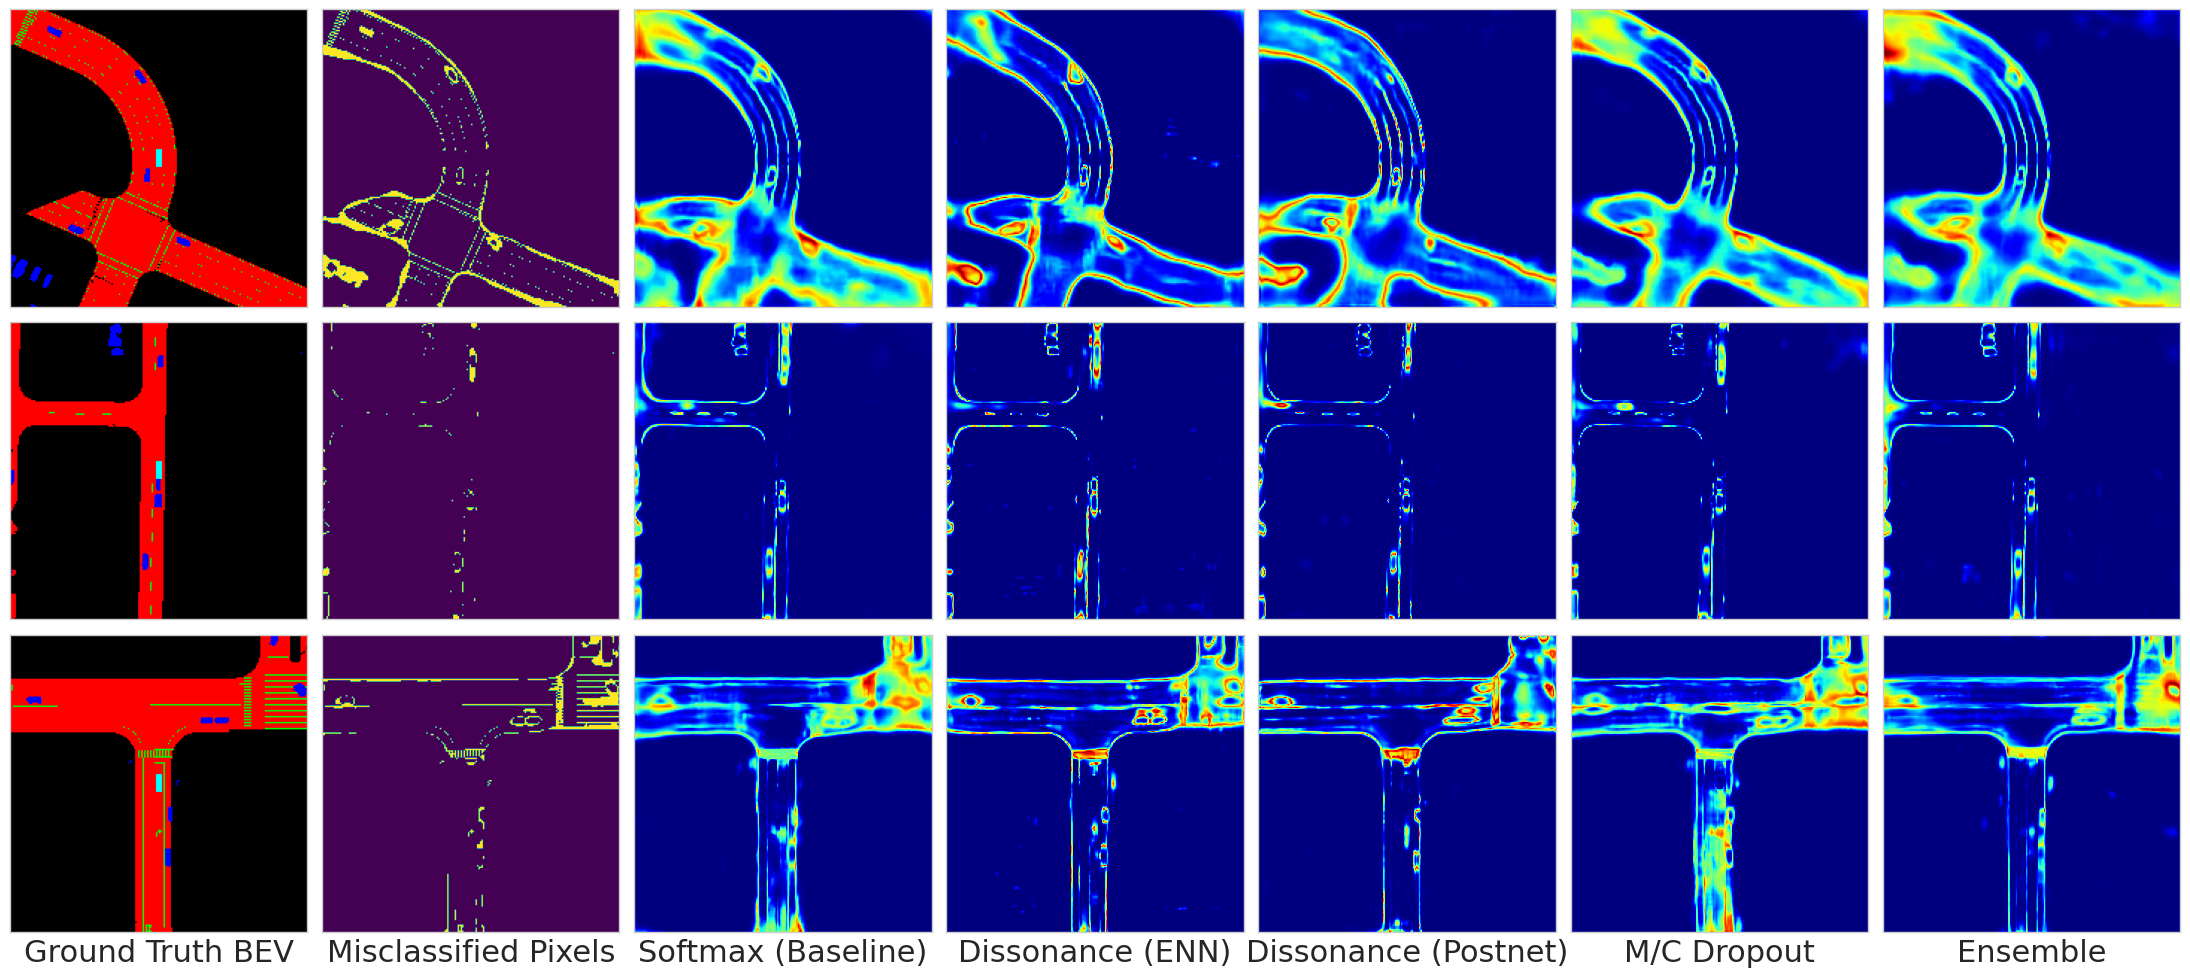

In [67]:

idxs = [500, 1000, 1500]
models = [baseline, evidential, postnet, dropout, ensemble]
nmodels = len(models)
samples = len(idxs)
size = 4

save = 'unc_frames_new'
os.makedirs(save, exist_ok=True)

fig, axs = plt.subplots(samples, nmodels+2, figsize=((nmodels + 2) * size, size * (samples)))
fig.subplots_adjust(wspace=.05, hspace=.05)

for ax in axs.flatten():
    ax.set_xticks([])
    ax.set_yticks([])
    ax.grid(False)

for k in trange(100):
    for i in range(samples):
        images, intrinsics, extrinsics, labels, ood = nusc_data[idxs[i] + k * 2]
        
        images = images[None].to(7)
        intrinsics = intrinsics[None].to(7)
        extrinsics = extrinsics[None].to(7)
        labels = labels[None].to(7)

        mis = torch.zeros((200, 200))

        for j, model in enumerate(models):
    
            logits = model(images, intrinsics, extrinsics).detach().cpu()
            al = model.aleatoric(logits)
        
            pmax = model.activate(logits).argmax(dim=1)
            lmax = labels.argmax(dim=1)
            m = pmax.cpu() != lmax.cpu()
            mis += m[0]
        
            axs[i, 0].imshow(map_rgb(labels[0], ego=True) / 255)
            axs[i, j + 2].imshow(al[0, 0], cmap='jet')
            
        mis = (mis > 1)
    
        axs[i, 1].imshow(mis, cmap='viridis')
    
    axs[samples-1, 0].set_xlabel("Ground Truth BEV", fontsize=22)
    axs[samples-1, 1].set_xlabel("Misclassified Pixels", fontsize=22)
    axs[samples-1, 2].set_xlabel("Softmax (Baseline)", fontsize=22)
    axs[samples-1, 3].set_xlabel("Dissonance (ENN)", fontsize=22)
    axs[samples-1, 4].set_xlabel("Dissonance (Postnet)", fontsize=22)
    axs[samples-1, 5].set_xlabel("M/C Dropout", fontsize=22)
    axs[samples-1, 6].set_xlabel("Ensemble", fontsize=22)
    fig.savefig(f"{save}/{k}.png", bbox_inches='tight')


In [320]:

fig = plt.figure(figsize=(10, 6.5))
gs = mpl.gridspec.GridSpec(4, 3)
gs.update(wspace=0.0, hspace=0.0, left=0.0, right=1.0, top=1.0, bottom=0.0)

blue_patch = mpatches.Patch(color='blue', label='vehicle')
red_patch = mpatches.Patch(color='red', label='road')
green_patch = mpatches.Patch(color='lime', label='lane')
black_patch = mpatches.Patch(color='black', label='background')

save = 'nuscenes_frames_lss'
os.makedirs(save, exist_ok=True)

for i in trange(0, 100):
    images, intrinsics, extrinsics, labels, ood = nusc_data[i]
    images = images[None].to(7)
    intrinsics = intrinsics[None].to(7)
    extrinsics = extrinsics[None].to(7)
    labels = labels[None].to(7)

    logits = baseline(images, intrinsics, extrinsics).detach().cpu()
    preds = baseline.activate(logits)
    
    for ci in range(6):
        ax = fig.add_subplot(gs[ci // 3, ci % 3])
        plt.annotate(cam_names[ci], (0.01, 0.92), xycoords='axes fraction')
        image = images[0, ci].cpu().permute(1, 2, 0).numpy()
        ax.imshow(image)
            
    ax = fig.add_subplot(gs[2:4, 0])
    ax.imshow(map_rgb(preds[0]) / 255)
    ax.set_xlabel("Prediction", fontsize=18)

    ax = fig.add_subplot(gs[2:4, 1])
    ax.imshow(map_rgb(labels[0]) / 255)
    ax.set_xlabel("Ground Truth", fontsize=18)
    
    fig.align_labels()

    for ax in fig.get_axes():
        ax.set_xticks([])
        ax.set_yticks([])
        ax.grid(False)

    fig.legend(handles=[blue_patch, red_patch, green_patch, black_patch], loc="lower right", fontsize=20, bbox_to_anchor=(1, .1))

    fig.savefig(f"{save}/{i}.png", bbox_inches='tight')
    plt.clf()

  0%|          | 0/100 [00:00<?, ?it/s]

<Figure size 1000x650 with 0 Axes>

In [ ]:
rat = 224/480
val = 10.1
fig = plt.figure(figsize=(val + val/3*2*rat*3, val/3*2*rat))
gs = mpl.gridspec.GridSpec(2, 6, width_ratios=(1, 1, 1, 2*rat, 2*rat, 2*rat))
gs.update(wspace=0.0, hspace=0.0, left=0.0, right=1.0, top=1.0, bottom=0.0)

images, intrinsics, extrinsics, labels, ood = ood_data[i]
images = images[None].to(7)
intrinsics = intrinsics[None].to(7)
extrinsics = extrinsics[None].to(7)
labels = labels[None].to(7)

logits = evidential(images, intrinsics, extrinsics).detach().cpu()
preds = evidential.activate(logits)

for ci in range(6):
    ax = plt.subplot(gs[ci // 3, ci % 3])
    plt.annotate(cam_names[ci], (0.01, 0.92), xycoords='axes fraction')
    ax.axis('off')
    image = images[0, ci].cpu().permute(1, 2, 0).numpy()
    ax.imshow(image)
        
ax = plt.subplot(gs[:, 3:4])
ax.imshow(map_rgb(preds[0]) / 255)
ax.set_xticks([])
ax.set_yticks([])
ax.grid(False)
ax.set_xlabel("Prediction")

ax = plt.subplot(gs[:, 4:5])
ax.imshow(map_rgb(labels[0]) / 255)
ax.set_xticks([])
ax.set_yticks([])
ax.grid(False)
ax.set_xlabel("Ground Truth")

ax = plt.subplot(gs[:, 5:6])
ax.imshow(evidential.epistemic(logits)[0, 0], cmap='jet')
ax.set_xticks([])
ax.set_yticks([])
ax.grid(False)
ax.set_xlabel("Epistemic Uncertainty")
